In [1]:
import pandas as pd
import numpy as np
import os, sys

In [2]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
from torch.utils.data.dataset import random_split

In [4]:
from time import sleep

In [5]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

In [6]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [7]:
def to_onehot(labels, n_categories, dtype=torch.float32):
    batch_size = len(labels)
    one_hot_labels = torch.zeros(size=(batch_size, n_categories), dtype=dtype)
    for i, label in enumerate(labels):
        # Subtract 1 from each LongTensor because your
        # indexing starts at 1 and tensor indexing starts at 0
        label = torch.LongTensor(label)
        one_hot_labels[i] = one_hot_labels[i].scatter_(dim=0, index=label, value=1.)
    return one_hot_labels

In [13]:
DATA_FOLDER = '../data'
FILE = 'train.csv'
DATA_PATH = '../data/ml-latest-small'

In [9]:
links_df = pd.read_csv(os.path.join(DATA_PATH, 'links.csv'))

In [10]:
ratings_df = pd.read_csv(os.path.join(DATA_PATH, 'ratings.csv')).query("rating >= 4").drop(columns=['rating', 'timestamp'])

In [14]:
contentMovie_df = pd.read_csv(os.path.join(DATA_FOLDER, FILE))

In [15]:
from gensim.models import Word2Vec
import torch.nn.functional as F
import spacy
nlp = spacy.load("en_core_web_sm")
spacy_sw = spacy.lang.en.stop_words.STOP_WORDS

def fct(doc):
    return ' '.join([w.lemma_ for w in doc 
            if w.lemma_ not in spacy_sw and 
            not w.is_punct and 
            w.tag_ != 'VBN'
           ])


def create_weight(text):
    desc = list(text)
    desc = [d 
            if type(d) is not np.float 
            else 'Nothing' 
            for d in desc]
    docs = nlp.pipe(desc)
    split_d = [fct(doc).split() for doc in docs]
    model_emb_w = Word2Vec(split_d, min_count=10, size=64)
    weights = torch.FloatTensor(model_emb_w.wv.vectors)
    weights = torch.cat((weights, weights.mean(0, keepdim=True)), dim=0)
    return weights, model_emb_w, split_d

In [16]:
text_df = contentMovie_df.iloc[:,:2]

In [17]:
id_desc = set(text_df.movieId)

In [18]:
ratings_df = pd.read_csv(os.path.join(DATA_PATH, 'ratings.csv')).query("rating >= 3 and movieId in @id_desc").drop(columns=['rating', 'timestamp'])

In [19]:
m_id = set((ratings_df.movieId.value_counts()[ratings_df.movieId.value_counts() > 5]).index)
u_id = set((ratings_df.userId.value_counts()[ratings_df.userId.value_counts() > 5]).index)
ratings_df.query("movieId in @m_id & userId in @u_id", inplace=True)

In [20]:
id2id = {e: i for i, e in enumerate(text_df.movieId.unique())}
ratings_df['movieId'] = ratings_df.movieId.map(id2id)

In [282]:
weights, model, split_d = create_weight(text_df.description)

In [283]:
vocab = list(model.wv.vocab)

In [284]:
word2id = [torch.LongTensor([vocab.index(w) for w in s if w in vocab]) for s in split_d]
# the final term is for padding
pad_int = len(vocab)

In [406]:
def Neg_Sample(x):
    line = (1  - x).nonzero()
    line = line[torch.multinomial(torch.ones(line.size(0)), 10, True)].t()
    return line

In [407]:
torch.cat([Neg_Sample(dataset.neg_samp[i]) for i in range(dataset.n)]).shape

torch.Size([15307, 10])

In [461]:
class RecoDataset(Dataset):
    def __init__(self, data, itemId, userId, word2id):
        
        self.itemId, self.userId = torch.LongTensor(data[itemId]), torch.LongTensor(data[userId])
        self.n_user, self.n_item = len(self.userId.unique()), len(self.itemId.unique())
        self.n = len(self.itemId)
        list_item = data.groupby(userId).agg(list)[itemId]
        ohe = to_onehot([list_item[u.item()] for u in self.userId], self.itemId.max() + 1, dtype=torch.float32)
        self.neg_samp = torch.cat([self.Neg_Sample(ohe[i]) for i in range(self.n)])
        
        desc_id = torch.nn.utils.rnn.pad_sequence(word2id, padding_value=pad_int, batch_first=True)
        self.movie_description = desc_id[self.itemId]
        
    def Neg_Sample(self, x):
        line = (1  - x).nonzero()
        line = line[torch.multinomial(torch.ones(line.size(0)), 3, True)].t()
        return line

    def __len__(self):
        return self.n
        
    def __getitem__(self, idx):
        return (self.itemId[idx], self.userId[idx], self.movie_description[idx], self.neg_samp[idx])

In [462]:
split= 0.8

In [463]:
dataset = RecoDataset(ratings_df, 'movieId', 'userId', word2id)
lengths = [int(dataset.__len__() * split), int(dataset.__len__() * (1-split)) + 1]
lengths = lengths if sum(lengths) == dataset.__len__() else [lengths[0], lengths[1] - 1]
train_data, test_data = random_split(dataset, lengths)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=True)

In [464]:
class RecoWithText(nn.Module):
    
    def __init__(self, nItem, nUser):
        super(RecoWithText, self).__init__()

        ## GMF
        self.embedding_user_gmf = torch.nn.Embedding(num_embeddings=nUser, embedding_dim=10)
        self.embedding_item_gmf = torch.nn.Embedding(num_embeddings=nItem, embedding_dim=10)      
        ## MLP
        self.embedding_user_mlp = torch.nn.Embedding(num_embeddings=nUser, embedding_dim=10)
        self.embedding_item_mlp = torch.nn.Embedding(num_embeddings=nItem, embedding_dim=10)
        self.nnItem = nn.Sequential(
            nn.Linear(10, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.nnUser = nn.Sequential(
            nn.Linear(10, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.nnFusion = nn.Sequential(
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 10),
        )
        # total
        self.affine_output = nn.Linear(in_features=10+10+10, out_features=1) #out_features=nItem)
        
        self.embedding = nn.Embedding.from_pretrained(weights)
        self.fc1 = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10)
        )
        
        self.logistic = nn.Sigmoid()  
        
    def forward(self, item, user, d):
        # GMF
        user_embedding_gmf = self.embedding_user_gmf(user)
        item_embedding_gmf = self.embedding_item_gmf(item)        
        x_gmf = torch.mul(user_embedding_gmf, item_embedding_gmf)
        # MLP
        user_embedding_mlp = self.embedding_user_mlp(user)
        item_embedding_mlp = self.embedding_item_mlp(item)
        x1 = self.nnItem(item_embedding_mlp)
        x2 = self.nnUser(user_embedding_mlp)
        x_mlp = torch.cat((x1, x2), dim=1)
        x_mlp = self.nnFusion(x_mlp)     
        # text layer
        d = self.embedding(d)
        d = d.mean(dim=1)
        d = self.fc1(d)
        # concat the two models
        vector = torch.cat((x_mlp, x_gmf, d), dim=1)   
        x = self.affine_output(vector)
        
        # x = self.logistic(logits)   
        return x

In [465]:
R = RecoWithText(ratings_df.movieId.max()+1, ratings_df.userId.max()+1)

In [466]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(R.parameters(), lr=0.001, betas=(0.5, 0.9))

In [467]:
all_losses = []
batches = 0

In [468]:
start = time.time()

for epoch in range(15):  # loop over the dataset multiple times

    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        items, users, d, neg_samp = data
        
        batch_size = items.size(0)

        pos_target = torch.ones(batch_size, 1)
        neg_target = torch.zeros(batch_size, 1)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs_pos = R(items, users, d)
        loss_neg = torch.tensor([0.])
        for i_neg in neg_samp.t():
            outputs_neg = R(i_neg, users, d)
            loss_neg += criterion(outputs_neg, neg_target)
            
        loss = (criterion(outputs_pos, pos_target) + loss_neg / 3)/2
        loss.backward()
        optimizer.step()

        # print statistics
        if i % 500 == 0:
            print('%s, %d %d %.4f' % (timeSince(start), epoch, batches, loss))
        all_losses.append(loss.item())
        batches += 1

print('Finished Training')

0m 0s, 0 0 1.3966
0m 3s, 0 500 0.9883
0m 5s, 1 766 1.0530
0m 8s, 1 1266 0.9421
0m 10s, 2 1532 0.8371
0m 13s, 2 2032 0.7776
0m 15s, 3 2298 0.9253
0m 19s, 3 2798 0.7879
0m 21s, 4 3064 0.8192
0m 24s, 4 3564 0.9106
0m 26s, 5 3830 0.6772
0m 30s, 5 4330 0.6756
0m 31s, 6 4596 0.5259
0m 35s, 6 5096 0.6735
0m 37s, 7 5362 0.6174
0m 40s, 7 5862 0.7107
0m 42s, 8 6128 0.7141
0m 46s, 8 6628 0.6679
0m 48s, 9 6894 0.6111
0m 51s, 9 7394 1.2597
0m 53s, 10 7660 0.6053
0m 57s, 10 8160 1.1230
0m 59s, 11 8426 0.5600
1m 2s, 11 8926 0.7502
1m 4s, 12 9192 0.6121
1m 8s, 12 9692 0.5522
1m 9s, 13 9958 0.8823
1m 13s, 13 10458 0.8211
1m 15s, 14 10724 0.5985
1m 18s, 14 11224 0.6684
Finished Training


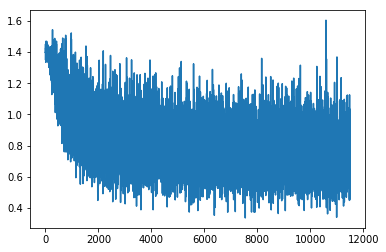

In [469]:
plt.figure()
plt.plot(all_losses)

In [470]:
correct = 0
correct_neg = 0
correct_pos = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        items, users, d, neg_samp = data
        batch_size = items.size(0)
        pos_target = torch.ones(batch_size, 1)
        neg_target = torch.zeros(batch_size, 1)
        outputs_pos = R(items, users, d)
        loss_neg = torch.tensor([0])
        for i_neg in neg_samp.t():
            outputs_neg = R(i_neg, users, d)
            loss_neg += criterion(outputs_neg, neg_target)
            
        total += targets.size(0)
        correct_pos += criterion(outputs_pos, pos_target).item()
        correct_neg += (loss_neg / 10).item()

In [476]:
(correct_pos + correct_neg) / total

0.021203025758344058